In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!nvidia-smi

Mon Jun 27 06:53:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Library

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 31.4 MB/s 
     |████████████████████████████████| 596 kB 68.1 MB/s 
     |████████████████████████████████| 101 kB 13.0 MB/s 
     |████████████████████████████████| 6.6 MB 51.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,multilabel_confusion_matrix,accuracy_score
import string
import re
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import shutil
import sys

## Import dataset

Dataset yang kami gunakan berasal dari github, namun sebenarnya ini adalah dataset yang dipakai untuk kompetisi kaggle.

dataset ini sendiri berisikan komen dari wikipedia

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/line-by-line/toxic_comments_classifier/master/Datasets%20from%20Kaggle%20(toxic)/train.csv')

In [ ]:
df.head(15)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
df.shape

(159571, 8)

In [ ]:
TARGETS = df.columns.tolist()[2:]
TARGETS

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


Buang column ID karena tidak penting untuk kasus ini

In [ ]:
df=df.iloc[:,1:]

# Explore the data

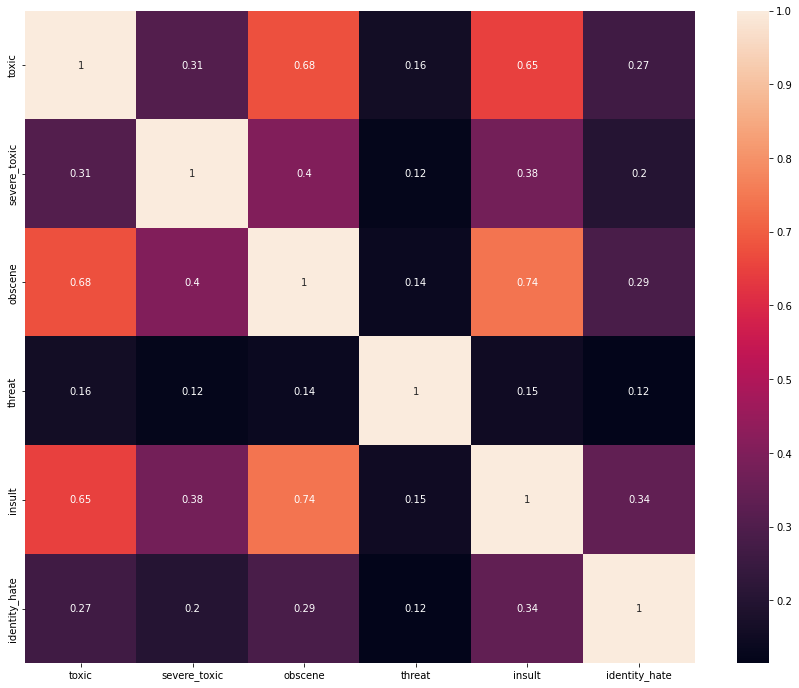

In [ ]:
plt.figure( figsize=[15,12])
_=sns.heatmap(df.corr(), annot= True)

In [ ]:
df.isnull().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
print("untuk toxic")
print(df['toxic'].value_counts(), '\n')

print("untuk severe_toxic")
print(df['severe_toxic'].value_counts(), '\n')

print("untuk obscene")
print(df['obscene'].value_counts(), '\n')

print("untuk threat")
print(df['threat'].value_counts())

print("untuk insult")
print(df['insult'].value_counts(),'\n')

print("untuk identity_hate")
df['identity_hate'].value_counts()

untuk toxic
0    144277
1     15294
Name: toxic, dtype: int64 

untuk severe_toxic
0    157976
1      1595
Name: severe_toxic, dtype: int64 

untuk obscene
0    151122
1      8449
Name: obscene, dtype: int64 

untuk threat
0    159093
1       478
Name: threat, dtype: int64
untuk insult
0    151694
1      7877
Name: insult, dtype: int64 

untuk identity_hate


0    158166
1      1405
Name: identity_hate, dtype: int64

In [ ]:
data_count=df.iloc[:,1:].sum()
data_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

# Kelompokkan data yang bersih dengan yang mengandung makna kasar/kotor

In [ ]:
clean_df = df[df[TARGETS].sum(axis=1) == 0]
clean_df.shape

(143346, 7)

In [ ]:
dirty_df = df[df[TARGETS].sum(axis=1) > 0]
dirty_df.shape

(16225, 7)

## Visualize jumlah komen dari tiap kelas dalam grafik

In [ ]:
data_count_list = list(data_count)
data_count_list

[15294, 1595, 8449, 478, 7877, 1405]

In [ ]:
label=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean']
data_count_list.append(clean_df.shape[0])
x=label
y=data_count_list

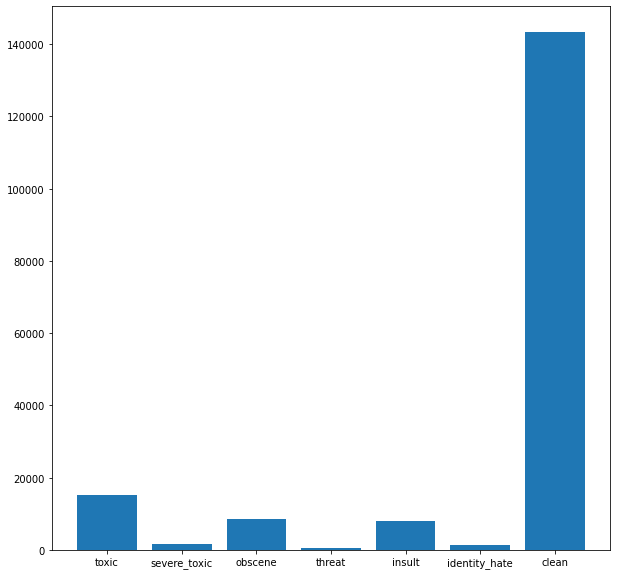

In [ ]:
plt.figure(figsize=(10,10))
x1=np.arange(7)
plt.bar(x=np.arange(7),height=y)
plt.xticks(x1,labels=x)
plt.show()

# Handling Imabalance dataset


In [ ]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Karena komen yang clean terlalu banyak, sehingga saya akan undersampling komen yang bersih dan oversampling beberapa kategori seperti severe_toxic, threat, identity_hate komen

In [ ]:
clean_df= clean_df.sample(18000,random_state=42).reset_index(drop=True)
clean_df.shape

(18000, 7)

In [ ]:
#secara spesifik saya mau oversampling komen threat yang betul2 threat dan bukan label lain. karena hanya trdpt 478 threat

threat_df = df[(df['threat'] == 1) & (df[TARGETS].sum(axis=1) == 1)]
# threat_df = threat_df.sample(1000,random_state=42, replace=True)
print(threat_df.shape)
threat_df.head(3)

(22, 7)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
3712,Please stop. If you continue to ignore our pol...,0,0,0,1,0,0
16939,That's funny. You was personally offended? So ...,0,0,0,1,0,0
17210,Wow dude. As your physician I suggest you sli...,0,0,0,1,0,0


In [ ]:
severe_df = df[(df['severe_toxic'] == 1) &(df[TARGETS].sum(axis=1) == 1)]
print(severe_df.shape)
severe_df.head(3)

(0, 7)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


ternyata, semua severe toxic pastilah diikuti label lain, saya menduga kemungkinan paling besar yaitu toxic. sehingga tidak ada row yang hanya  mengandung severe toxic saja

In [ ]:
severe_df = df[(df['severe_toxic'] == 1) &(df['toxic'] == 0) ]
print(severe_df.shape)
severe_df.head(3)

(0, 7)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


Ternyata betul bahwa jika saya mensyaratkan severe toxic true dan toxic false, maka tidak ada data yang muncul. ini wajar karena severe toxic yang berarti toxic yang serius sudah pasti harus toxic, maka saya putuskan untuk sekalian saja oversampling seluruh komen yang severe. dengan alasan dapat sekalian menambah jumlah komen di label lain

In [ ]:
severe_df = df[(df['severe_toxic'] == 1)]
print(severe_df.shape)
severe_df.head(3)

(1595, 7)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
55,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
181,you are a stupid fuck \n\nand your mother's cu...,1,1,1,0,1,0


In [ ]:
identity_df = df[(df['identity_hate'] == 1) & (df[TARGETS].sum(axis=1) == 1)]
print(identity_df.shape)
identity_df.head(3)

(54, 7)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
3620,"Mate, sound like you are jewish\n\nGayness is ...",0,0,0,0,0,1
5839,"it is obvius to, me, a black man, that orange ...",0,0,0,0,0,1
13201,"The Israelis are committing massacres in Gaza,...",0,0,0,0,0,1


In [ ]:
# Oversampling kelas yg punya komen sedikit. tidak ada aturan khusus untuk ini
threat_df=threat_df.sample(2500, random_state=42, replace=True)
severe_df= severe_df.sample(2500, random_state=42, replace=True)
identity_df= identity_df.sample(2500, random_state=42, replace=True)

In [ ]:
dirty_df= pd.concat([dirty_df, threat_df, identity_df, severe_df])

In [ ]:
dirty_df.shape

(23725, 7)

In [ ]:
concat_df= pd.concat([clean_df, dirty_df])
concat_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"""\n\nOh, don't worry about me, Sandstein. I'm ...",0,0,0,0,0,0
1,Are you trying to dispute that fact?,0,0,0,0,0,0
2,SWOT analysis \n\nThis source – Align Technolo...,0,0,0,0,0,0
3,"cover \n\nso, do we want a current or older co...",0,0,0,0,0,0
4,P.S. It's probably worth setting up a template...,0,0,0,0,0,0


In [ ]:
concat_df.shape

(41725, 7)

Kita shuffle agar tidak monoton

In [ ]:
concat_df= concat_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [ ]:
concat_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"""\n\nTell you the truth, I really don't mind t...",1,0,0,0,0,0
1,Quote by Chen in intro \n\nI did not see anyth...,0,0,0,0,0,0
2,"""\n\n Response \n\n1. Photo selection: On 3/15...",0,0,0,0,0,0
3,"I am open to your idea, which I think is desis...",0,0,0,0,0,0
4,Rather than simply deleting the picture of a g...,0,0,0,0,0,0


## Lihat persebaran untuk concat df yang kita punya sekarang

In [ ]:
data_count_concat=concat_df.iloc[:,1:].sum()
data_count_concat

toxic            17794
severe_toxic      4095
obscene          10855
threat            3158
insult           10032
identity_hate     4384
dtype: int64

In [ ]:
data_count_concat_list = list(data_count_concat)

[17794, 4095, 10855, 3158, 10032, 4384]

In [ ]:
label=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean']
data_count_concat_list.append(clean_df.shape[0])
x=label
y=data_count_concat_list

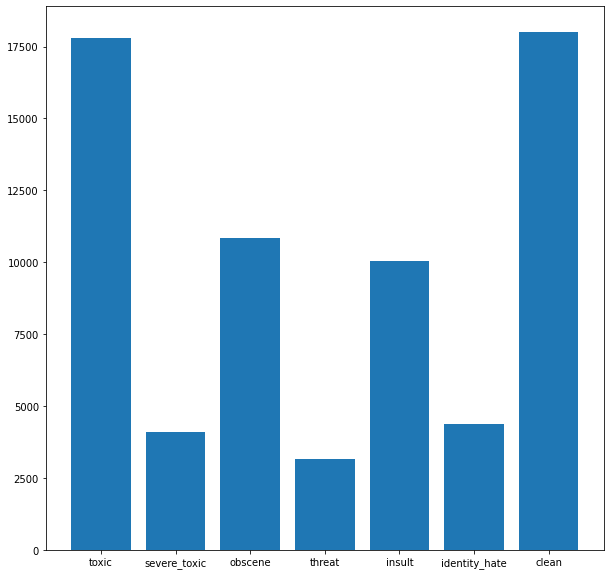

In [ ]:
plt.figure(figsize=(10,10))
x1=np.arange(7)
plt.bar(x=np.arange(7),height=y)
plt.xticks(x1,labels=x)
plt.show()

#Clean Texts

buang '\\n' dan juga remove double space

In [ ]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
concat_df['comment_text'] = concat_df['comment_text'].map(alphanumeric)
concat_df['comment_text']= concat_df['comment_text'].map(lambda x: re.sub(r'\n',r' ', x))
concat_df['comment_text']= concat_df['comment_text'].map(lambda x: re.sub(r'  ',r' ', x))
concat_df['comment_text']=concat_df['comment_text'].str.strip()

In [ ]:
concat_df['comment_text'][0]

'" Tell you the truth, I really don\'t mind this block at all. I did harass. That is what you do in a war where no one plays by the rules. Quite frankly I am fed up with being constantly blocked by silly Wiki morons and am glad I said it. We all know the politics around here so let\'s stop talking past each other, right? Look at why I was deleted leading to all this, not after World war III was in mid session. Who Started it? Not I! Until Wikipedia deals with morons I have no choice but to retain this position as this madness known as ""Wikipedia"" writes trash on my life. Liberals will do what liberals do: Level the playing field for the idiots, and I will be there to respond."'

# Split into train and test

In [ ]:
df_train, df_test= train_test_split(concat_df,test_size=0.1, random_state=42)
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [ ]:
df_train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Isabelle Fuhrman Thanks for removing something...,0,0,0,0,0,0
1,"BJP pro hindutva , aren't you living in this ...",1,0,0,0,0,0
2,"Sup dude. I'm not spamming. Fuck you, learn to...",1,0,1,0,1,0
3,"Dear Snigbrook Your days are numbered, the sta...",1,0,1,1,1,0
4,""" She did the usual disappear at Christmas act...",0,0,0,0,0,0


# Bert PyTorch

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 1e-05

In [ ]:
class CustomDataset (torch.utils.data.Dataset):
  def __init__(self,df,tokenizer,max_len):
    self.df= df
    self.comment= df['comment_text']
    self.targets = df[TARGETS].values

    self.tokenizer=tokenizer
    self.max = max_len
  
  def __len__(self):
    return len(self.comment)

  def __getitem__(self,index):
    comment= str(self.comment[index])
    comment = " ".join(comment.split())

    inputs = self.tokenizer.encode_plus(
        comment,
        None,
        add_special_tokens= True,
        max_length= self.max,
        padding= 'max_length',
        truncation= True,
        return_token_type_ids= True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }


In [ ]:
df_train= CustomDataset(df_train, tokenizer, MAX_LEN)
df_test= CustomDataset(df_test, tokenizer,MAX_LEN)

In [ ]:
print(df_test.df['comment_text'][2])
print(df_test[2])

Your Erectile Dysfunction== Sorry for making fun of it earlier.  ==
{'input_ids': tensor([  101,  2115, 14908,  9463, 28466,  1027,  1027,  3374,  2005,  2437,
         4569,  1997,  2009,  3041,  1012,  1027,  1027,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

In [ ]:
train_data_loader = torch.utils.data.DataLoader(df_train, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(df_test, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create Checkpoint

In [ ]:
def load_ckp(checkpoint_fpath, model):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, checkpoint['epoch'], valid_loss_min

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

# BERT CLASS

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 6)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

# Training

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
"trainable parameters are " + str(count_parameters(model)) + " parameters"

'trainable parameters are 109486854 parameters'

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
def train_model(n_epochs, training_loader, validation_loader, model,checkpoint_path,
                 best_model_path,optimizer):
   
  valid_loss_min = np.Inf
  
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0
    val_targets=[]
    val_outputs=[]

    model.train()

    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)

    # validate the model #
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            # print("pnjg target", len(val_targets))
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            # print("pnjg outputs", len(val_outputs))

      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.5f} \tAverage Validation Loss: {:.5f} acurracy score = {:.5f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            roc_auc_score(val_targets, val_outputs)
            ))
      # print("roc score", roc_auc_score(val_targets, val_outputs))
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.5f} --> {:.5f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [ ]:
checkpoint="/content/drive/MyDrive/NaturalLanguageProcessingProject/curr_ckpt.pt"
bestModel= "/content/drive/MyDrive/NaturalLanguageProcessingProject/best.pt"
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
trained_model = train_model(EPOCHS,train_data_loader,val_data_loader,model,checkpoint,bestModel,optimizer)

Epoch: 1 	Avgerage Training Loss: 0.00018 	Average Validation Loss: 0.00100 acurracy score = 0.98039
Validation loss decreased (inf --> 0.00100).  Saving model ...
############# Epoch 1  Done   #############

Epoch: 2 	Avgerage Training Loss: 0.00011 	Average Validation Loss: 0.00094 acurracy score = 0.98390
Validation loss decreased (0.00100 --> 0.00094).  Saving model ...
############# Epoch 2  Done   #############

Epoch: 3 	Avgerage Training Loss: 0.00009 	Average Validation Loss: 0.00090 acurracy score = 0.98435
Validation loss decreased (0.00094 --> 0.00090).  Saving model ...
############# Epoch 3  Done   #############

Epoch: 4 	Avgerage Training Loss: 0.00007 	Average Validation Loss: 0.00093 acurracy score = 0.98408
############# Epoch 4  Done   #############



# Load Model

In [ ]:
final_model, epch, loss= load_ckp(bestModel, model)

In [ ]:
print(epch)
print(loss)

4
0.0009024845699206436


In [ ]:
val_outputs=[]
y_true=[]
final_model.eval()
valid_loss_final=0
with torch.no_grad():
      for batch_idx, data in enumerate(val_data_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            y_true.extend(targets.cpu().detach().numpy().tolist())
            # print("pnjg target", len(val_targets))
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

In [ ]:
roc_auc_score(y_true,val_outputs)

0.9843634084993828

In [ ]:
print(val_outputs)

[[0.002980106044560671, 0.008328205905854702, 0.004795635584741831, 0.008980686776340008, 0.0074721141718328, 0.9787561893463135], [0.003308660350739956, 0.0012437779223546386, 0.0019490942358970642, 0.010450899600982666, 0.0020380865316838026, 0.0017866493435576558], [0.7986454963684082, 0.009319816716015339, 0.5912877917289734, 0.0018249853746965528, 0.03225909546017647, 0.0016026848461478949], [0.9691023230552673, 0.02221098355948925, 0.28678616881370544, 0.26858004927635193, 0.36902427673339844, 0.017333071678876877], [0.0053559900261461735, 0.011011950671672821, 0.004140350967645645, 0.991040050983429, 0.006590551696717739, 0.009662310592830181], [0.9984349608421326, 0.8003066778182983, 0.9963570237159729, 0.011426038108766079, 0.9510974287986755, 0.027951540425419807], [0.9954238533973694, 0.20914417505264282, 0.9753952622413635, 0.0021557104773819447, 0.48378413915634155, 0.06886786222457886], [0.0036802568938583136, 0.0014160480350255966, 0.002468350576236844, 0.001802478102035

In [ ]:
len(val_outputs)

4173

# Evaluate Model

karena hasil prediksi dalam list 2 dimensi, maka ketika memanggil accuracy_score harus menggunakan .flatten() yang mengubah menjadi 1 dimensi

In [ ]:
def convert(lst):
  y_pred=[]
  for sample in lst:
    y_pred.append([1 if i>=0.4 else 0 for i in sample])
  return y_pred

y_pred= convert(val_outputs)
roc_auc_score(y_true,y_pred), accuracy_score(np.array(y_true).flatten(),np.array(y_pred).flatten())

(0.9324949825174172, 0.9499161274862209)

In [ ]:
print(y_pred)

[[1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 0], [1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 0], [1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 1, 1], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 1, 0], [1, 1, 1, 0, 1, 0], [1, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 1, 0], [1, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, 0],

In [ ]:
print(classification_report(y_true, y_pred,target_names=TARGETS))

               precision    recall  f1-score   support

        toxic       0.90      0.96      0.93      1772
 severe_toxic       0.74      0.87      0.80       419
      obscene       0.82      0.94      0.88      1074
       threat       0.93      0.95      0.94       319
       insult       0.77      0.89      0.82       985
identity_hate       0.85      0.88      0.86       429

    micro avg       0.84      0.92      0.88      4998
    macro avg       0.84      0.91      0.87      4998
 weighted avg       0.84      0.92      0.88      4998
  samples avg       0.48      0.52      0.49      4998



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
multilabel_confusion_matrix(y_true, y_pred)

array([[[2216,  185],
        [  74, 1698]],

       [[3628,  126],
        [  56,  363]],

       [[2884,  215],
        [  67, 1007]],

       [[3831,   23],
        [  17,  302]],

       [[2925,  263],
        [ 110,  875]],

       [[3678,   66],
        [  52,  377]]])

toxic
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94      2401
         1.0       0.90      0.96      0.93      1772

    accuracy                           0.94      4173
   macro avg       0.93      0.94      0.94      4173
weighted avg       0.94      0.94      0.94      4173



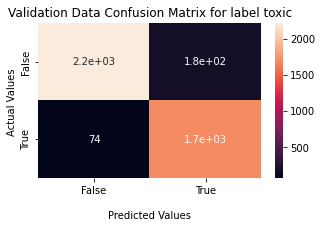




severe_toxic
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      3754
         1.0       0.74      0.87      0.80       419

    accuracy                           0.96      4173
   macro avg       0.86      0.92      0.89      4173
weighted avg       0.96      0.96      0.96      4173



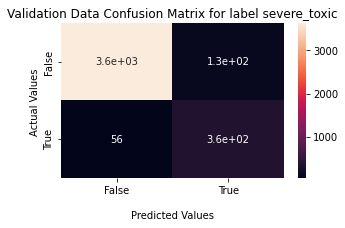




obscene
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      3099
         1.0       0.82      0.94      0.88      1074

    accuracy                           0.93      4173
   macro avg       0.90      0.93      0.92      4173
weighted avg       0.94      0.93      0.93      4173



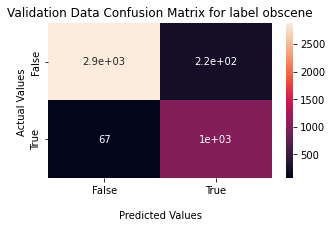




threat
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3854
         1.0       0.93      0.95      0.94       319

    accuracy                           0.99      4173
   macro avg       0.96      0.97      0.97      4173
weighted avg       0.99      0.99      0.99      4173



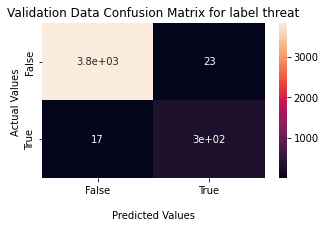




insult
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      3188
         1.0       0.77      0.89      0.82       985

    accuracy                           0.91      4173
   macro avg       0.87      0.90      0.88      4173
weighted avg       0.92      0.91      0.91      4173



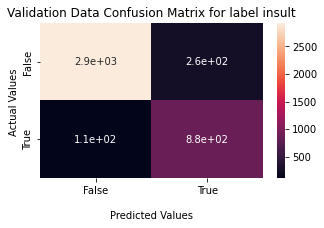




identity_hate
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      3744
         1.0       0.85      0.88      0.86       429

    accuracy                           0.97      4173
   macro avg       0.92      0.93      0.92      4173
weighted avg       0.97      0.97      0.97      4173



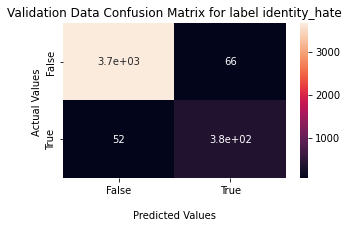

In [ ]:
i=0
for label in TARGETS:
  plt.figure(figsize=(5,20))
  print(label)
  plt.subplot(6,1,i+1)
  true= [values[i] for values in y_true]
  pred= [values[i] for values in y_pred]
  i+=1
  print(classification_report(true,pred))
  ax=sns.heatmap(confusion_matrix(true,pred), annot=True)
  ax.set_title(f'Validation Data Confusion Matrix for label {label}')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')

  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])
  # plt.tight_layout(pad=0.54, w_pad=2)
  plt.show()
  print("\n\n")

#Test with random comment

In [ ]:
example = "you lil piece of sh*t mfs"
encodings = tokenizer.encode_plus(
    example,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
final_model.eval()
with torch.no_grad():
    input_ids = encodings['input_ids'].to(device, dtype=torch.long)
    attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
    output = model(input_ids, attention_mask, token_type_ids)
    final_output = torch.sigmoid(output).cpu().detach().numpy().flatten().tolist()
    # print(final_output)
    # print(TARGETS[y for y in final_output if y>=0.2])
    predictions = []
    for idx, label in enumerate(TARGETS):
      if final_output[idx] >= 0.4:
        predictions.append((label, round(final_output[idx]*100, 2)))

if(len(predictions) ==0 ): print("Clean Comment")
else: print(predictions)

[('toxic', 99.05), ('obscene', 92.11), ('insult', 94.51)]


#FINISH

=================================================================================================================================================================

In [ ]:
trained_model = train_model(EPOCHS,train_data_loader,val_data_loader,model,checkpoint,bestModel,optimizer)

Epoch: 1 	Avgerage Training Loss: 0.00016 	Average Validation Loss: 0.00140 acurracy score = 0.96659
Validation loss decreased (inf --> 0.00140).  Saving model ...
############# Epoch 1  Done   #############

Epoch: 2 	Avgerage Training Loss: 0.00014 	Average Validation Loss: 0.00153 acurracy score = 0.96436
############# Epoch 2  Done   #############

Epoch: 3 	Avgerage Training Loss: 0.00012 	Average Validation Loss: 0.00151 acurracy score = 0.96537
############# Epoch 3  Done   #############

Epoch: 4 	Avgerage Training Loss: 0.00010 	Average Validation Loss: 0.00158 acurracy score = 0.96344
############# Epoch 4  Done   #############



# Disini sedikit perbandingan apabila tidak dilakukan penanganan untuk imbalance dataset

 variabel target dan predictions saya assign sesuai dengan result dari running di kaggle

In [ ]:
def convert(lst):
  y_pred=[]
  for sample in lst:
    y_pred.append([1 if i>=0.4 else 0 for i in sample])
  return y_pred

In [ ]:
y_pred=convert(predictions)

In [ ]:
print(classification_report(target, y_pred, target_names=TARGETS))

               precision    recall  f1-score   support

        toxic       0.83      0.86      0.84      1480
 severe_toxic       0.37      0.79      0.51       148
      obscene       0.76      0.89      0.82       836
       threat       0.33      0.46      0.39        37
       insult       0.72      0.84      0.78       791
identity_hate       0.52      0.50      0.51       147

    micro avg       0.73      0.84      0.78      3439
    macro avg       0.59      0.72      0.64      3439
 weighted avg       0.75      0.84      0.79      3439
  samples avg       0.07      0.08      0.07      3439



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


toxic
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     14478
         1.0       0.83      0.86      0.84      1480

    accuracy                           0.97     15958
   macro avg       0.91      0.92      0.91     15958
weighted avg       0.97      0.97      0.97     15958



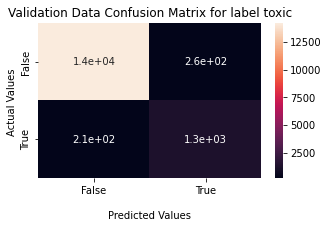




severe_toxic
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     15810
         1.0       0.37      0.79      0.51       148

    accuracy                           0.99     15958
   macro avg       0.69      0.89      0.75     15958
weighted avg       0.99      0.99      0.99     15958



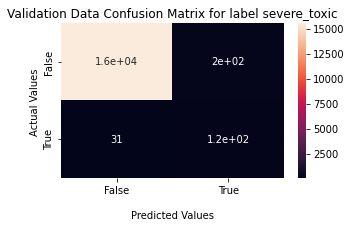




obscene
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     15122
         1.0       0.76      0.89      0.82       836

    accuracy                           0.98     15958
   macro avg       0.88      0.94      0.90     15958
weighted avg       0.98      0.98      0.98     15958



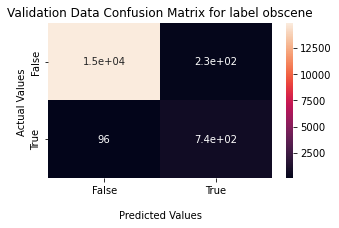




threat
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15921
         1.0       0.33      0.46      0.39        37

    accuracy                           1.00     15958
   macro avg       0.67      0.73      0.69     15958
weighted avg       1.00      1.00      1.00     15958



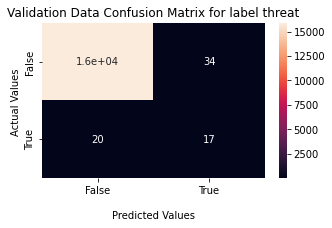




insult
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     15167
         1.0       0.72      0.84      0.78       791

    accuracy                           0.98     15958
   macro avg       0.86      0.91      0.88     15958
weighted avg       0.98      0.98      0.98     15958



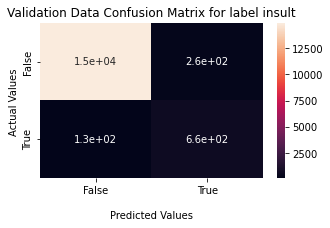




identity_hate
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15811
         1.0       0.52      0.50      0.51       147

    accuracy                           0.99     15958
   macro avg       0.76      0.75      0.75     15958
weighted avg       0.99      0.99      0.99     15958



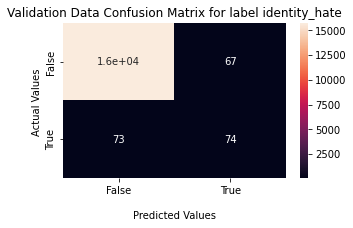

In [ ]:
i=0
for label in TARGETS:
  plt.figure(figsize=(5,20))
  print(label)
  plt.subplot(6,1,i+1)
  true= [values[i] for values in target]
  pred= [values[i] for values in y_pred]
  i+=1
  print(classification_report(true,pred))
  ax=sns.heatmap(confusion_matrix(true,pred), annot=True)
  ax.set_title(f'Validation Data Confusion Matrix for label {label}')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')

  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])
  # plt.tight_layout(pad=0.54, w_pad=2)
  plt.show()
  print("\n\n")

# Perbandingan jika hanya undersampling data clean dan tidak oversampling data yang dirty

In [ ]:
multilabel_confusion_matrix(y_true, y_pred)

array([[[1484,  264],
        [  23, 1452]],

       [[2903,  171],
        [  38,  111]],

       [[2189,  211],
        [  62,  761]],

       [[3124,   56],
        [  11,   32]],

       [[2099,  356],
        [  83,  685]],

       [[3018,   67],
        [  50,   88]]])

In [ ]:
print(classification_report(y_true, y_pred,target_names=TARGETS))

               precision    recall  f1-score   support

        toxic       0.85      0.98      0.91      1475
 severe_toxic       0.39      0.74      0.52       149
      obscene       0.78      0.92      0.85       823
       threat       0.36      0.74      0.49        43
       insult       0.66      0.89      0.76       768
identity_hate       0.57      0.64      0.60       138

    micro avg       0.74      0.92      0.82      3396
    macro avg       0.60      0.82      0.69      3396
 weighted avg       0.75      0.92      0.83      3396
  samples avg       0.38      0.45      0.39      3396



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


toxic
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      1748
         1.0       0.85      0.98      0.91      1475

    accuracy                           0.91      3223
   macro avg       0.91      0.91      0.91      3223
weighted avg       0.92      0.91      0.91      3223



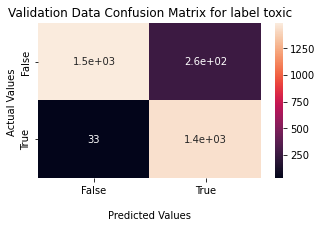




severe_toxic
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97      3074
         1.0       0.40      0.74      0.52       149

    accuracy                           0.94      3223
   macro avg       0.69      0.84      0.74      3223
weighted avg       0.96      0.94      0.94      3223



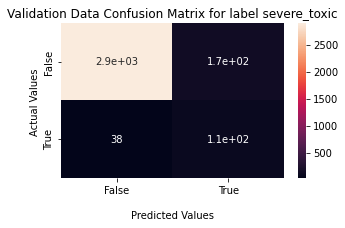




obscene
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      2400
         1.0       0.78      0.92      0.85       823

    accuracy                           0.91      3223
   macro avg       0.88      0.92      0.89      3223
weighted avg       0.92      0.91      0.92      3223



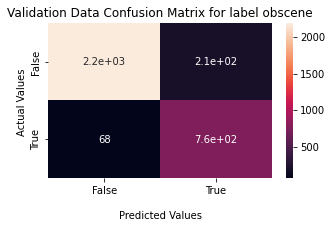




threat
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      3180
         1.0       0.36      0.72      0.48        43

    accuracy                           0.98      3223
   macro avg       0.68      0.85      0.74      3223
weighted avg       0.99      0.98      0.98      3223



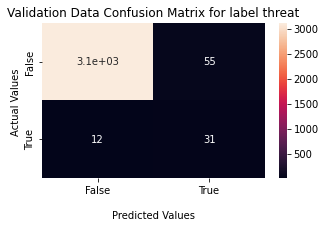




insult
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.90      2455
         1.0       0.66      0.89      0.75       768

    accuracy                           0.86      3223
   macro avg       0.81      0.87      0.83      3223
weighted avg       0.89      0.86      0.87      3223



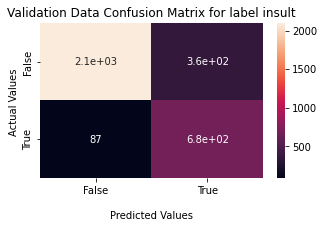




identity_hate
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3085
         1.0       0.57      0.64      0.60       138

    accuracy                           0.96      3223
   macro avg       0.78      0.81      0.79      3223
weighted avg       0.97      0.96      0.96      3223



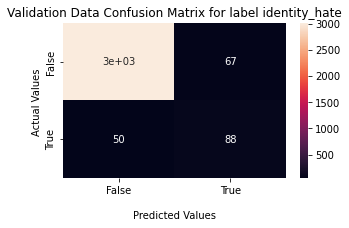

In [ ]:
i=0
for label in TARGETS:
  plt.figure(figsize=(5,20))
  print(label)
  plt.subplot(6,1,i+1)
  true= [values[i] for values in y_true]
  pred= [values[i] for values in y_pred]
  i+=1
  print(classification_report(true,pred))
  ax=sns.heatmap(confusion_matrix(true,pred), annot=True)
  ax.set_title(f'Validation Data Confusion Matrix for label {label}')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')

  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])
  # plt.tight_layout(pad=0.54, w_pad=2)
  plt.show()
  print("\n\n")